# Project 1 - Simulation and Estimation in a Markov Model of Breast Cancer

We are Group #13 comprised of the following students:
    
    Ioannis Koumaniotis - s212887
    Georgios Kapakoglou - s223001
    Anastasios Mavridis - s230093
    Dimitris Sousounis - s230118

## Packages Initiation

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import random as random
from scipy.linalg import expm
import statistics as st
from math import sqrt

## Part 1 - A discrete-time model

In this report, we will apply Markov chain simulations in order to model the time evolution of a system. The system we are dealing with is the population distribution of women with breast cancer after they have had their tumor removed surgically. The states we will divide the dataset into are as follows:

    1. Women without cancer reappearing.
    2. Cancer reappearing locally.
    3. Cancer reappearing elsewhere in the body.
    4. Both metastasis and local cancer resurgence.
    5. Patient death.

Since in most scenarios, we are interested in modeling immediately after surgery, our initial distributions will have only state 1 populated with the whole sample.

### Task 1

For the discrete model that updates each month, we are given the probability matrix P. We will now discuss the theoretical prediction. First we construct a vector with the initial probability distribution p0, and we will retrieve its future evolution at each subsequent month by repeatedly applying the matrix P to p0. 

In this simulation scenario however, we start with 1000 women, all belonging to state 1 in the initial distribution p0, and we begin from month 0, signifying the first month after surgery.

We will introduce a loop where for each woman, we call a multinomial random function, which we feed with the probability weights from the matrix P. Finally, we will store in an array the months in which we observe death events. In that way we have a measure of the survival percentage for each month.

In [47]:
P = np.array([[0.9915, 0.005, 0.0025, 0, 0.001],
              [0, 0.986, 0.005, 0.004, 0.005],
              [0, 0, 0.992, 0.003, 0.005],
              [0, 0, 0, 0.991, 0.009],
              [0, 0, 0, 0, 1]])
x=np.random.multinomial(1 , P[4,:], size=1)
x

array([[0, 0, 0, 0, 1]])

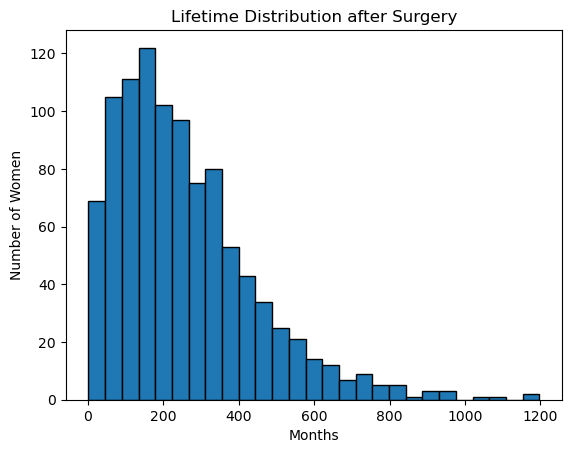

Proportion of women where the cancer reappeared locally: 0.5770


In [48]:
# Define the probability matrix P
P = np.array([[0.9915, 0.005, 0.0025, 0, 0.001],
              [0, 0.986, 0.005, 0.004, 0.005],
              [0, 0, 0.992, 0.003, 0.005],
              [0, 0, 0, 0.991, 0.009],
              [0, 0, 0, 0, 1]])

# Define the initial distribution p0 with all women starting in state 1
p0 = np.array([1, 0, 0, 0, 0])

# Simulate the lifetime distribution for 1000 women
num_women = 1000
lifetime_discrete = []
local_recurrence_count = 0

for _ in range(num_women):
    state = 0  # Start in state 1 (post-surgery)
    months = 0
    new_woman = True

    while state != 4:  # Continue simulation until death (state 5) is reached
        months += 1
        state = np.argmax(np.random.multinomial(1 , P[state,:], size=1))

        if state == 1 and new_woman == True:
            local_recurrence_count += 1
            new_woman = False

    lifetime_discrete.append(months)

# Calculate the proportion of women where the cancer reappeared locally (state 2)
reappeared_locally = local_recurrence_count/num_women

# Plot the lifetime distribution as a histogram
plt.hist(lifetime_discrete, bins="auto", edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Number of Women')
plt.title('Lifetime Distribution after Surgery')
plt.show()

print("Proportion of women where the cancer reappeared locally: {:.4f}".format(reappeared_locally))


### Task 2

In this task, we will obtain the distribution of women at each stage after 120 months have elapsed since surgery. Using a similar method, we will now run the following code where we store each woman's state at t=120 once in the list state_counts. We are interested in comparing our simulation results from to the theoretical one by applying the matrix P on p0. Lastly we are plotting the obtained distributions and use the χ^2 test to compare our results.

Simulated distribution at t = 120:
[0.345 0.159 0.183 0.073 0.24 ]
Expected distribution at t = 120:
[0.35902627 0.15895604 0.1660869  0.06774149 0.2481893 ]

Chi-squared test results:
Chi-squared statistic: 2.9487061413282167
P-value: 0.5664456775848148


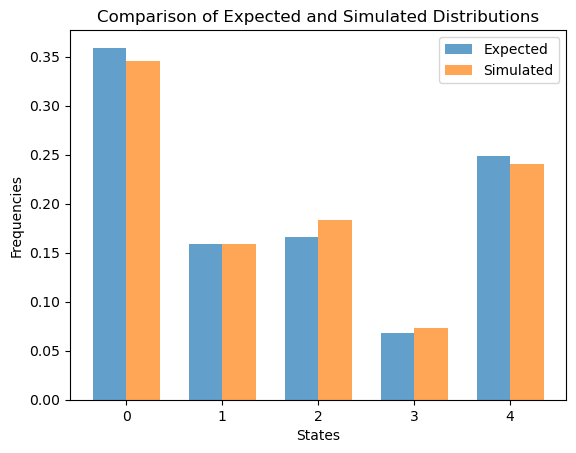

In [49]:
# Specify the time t for which you want to calculate the distribution
t = 120

state_counts = np.zeros(5)  # Initialize state counts

for _ in range(num_women):
    state = 1  # Start in state 1 (post-surgery)

    for _ in range(t):
        state = np.random.choice(np.arange(1, 6), p=P[state - 1])

    state_counts[state - 1] += 1

# Compute the simulated distribution at time t
pt_simulated = state_counts / num_women
#print(sum(pt_simulated))

# Print the simulated distribution at t = 120
print("Simulated distribution at t = 120:")
print(pt_simulated)

# Define the expected distribution at time t = 120
pt_expected = p0.dot(np.linalg.matrix_power(P, t))

# Print the expected distribution at t = 120
print("Expected distribution at t = 120:")
print(pt_expected)

# Perform chi-squared test
chi2, p_value = stats.chisquare(f_obs=state_counts, f_exp=pt_expected * num_women)

# Print the chi-squared test results
print("\nChi-squared test results:")
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p_value}")

# Bar plot of the simulated and expected distributions at t=120
states = [1, 2, 3, 4, 5]
bar_width = 0.35
indices = np.arange(len(states))
plt.bar(indices - bar_width/2, pt_expected, bar_width, alpha=0.7, label='Expected')
plt.bar(indices + bar_width/2, pt_simulated, bar_width, alpha=0.7, label='Simulated')
plt.xlabel('States')
plt.ylabel('Frequencies')
plt.title('Comparison of Expected and Simulated Distributions')
plt.legend()
plt.show()


### Task 3

We will now take a different approach that compares the test at all times without restricting ourselves with a specific month choice. We decompose the P matrix into two submatrices, one with 4 states where the women are alive and one where they are deceased. The empirical time-dependent lifetime distribution is obtained by the dot product of the ps 4d vector that contains the death probabilities for each state and at all times with the 4-state distribution π at time t, which is the partial distribution, excluding state 4. This amplitude essentially holds the theoretical information about the mortality rate, which we consequently compare to our simulation results using the χ^2 test

Chi-square statistic: 1.38
P-value: 1.0000
Mean Lifetime (Theoretical): 262.37
Mean Lifetime (Empirical): 258.83


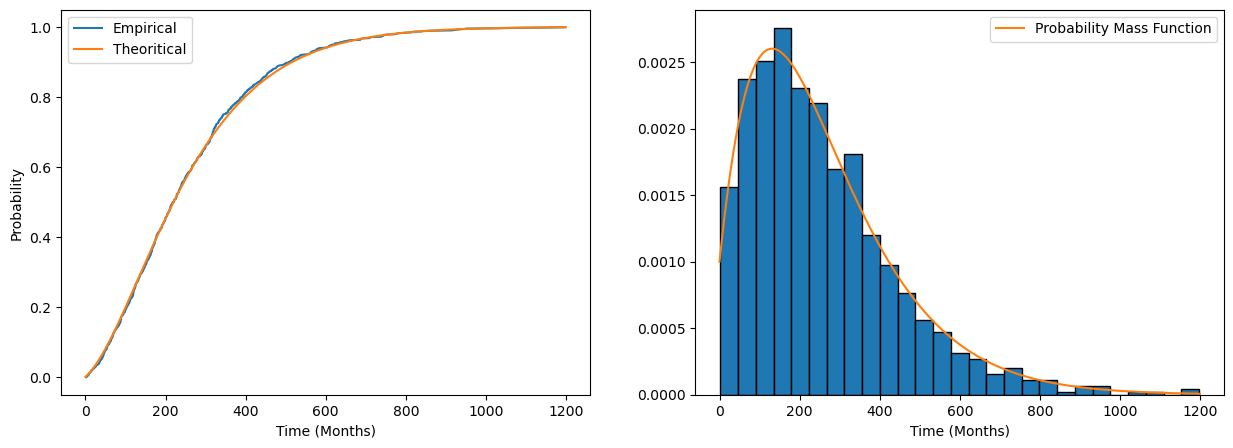

In [50]:
# Define the initial distribution pi with all women starting in state 1
pi = np.array([1, 0, 0, 0])

# Calculate the sub-matrix Ps and vector ps
Ps = P[:4, :4]
ps = P[:4, 4]

# Calculate the distribution over lifetimes based on the theoretical formula
def pmf(t):
    Pt = np.linalg.matrix_power(Ps, t)
    return pi@Pt@ps

# Calculate the mean lifetime based on the theoretical formula
mean_lifetime = pi.dot(np.linalg.inv(np.eye(4) - Ps).dot(np.ones(4)))

# Calculate the observed frequencies in the empirical lifetime distribution
observed_frequencies, bins = np.histogram(lifetime_discrete, density=True, bins=range(1201))

# Calculate the expected frequencies based on the theoretical distribution
expected_frequencies = np.array([pmf(t) for t in range(1200)])

# Normalize the expected frequencies to match the sum of observed frequencies
expected_frequencies *= np.sum(observed_frequencies) / np.sum(expected_frequencies)

# Perform the chi-square test to compare the empirical and theoretical distributions
chi2, p_value = stats.chisquare(observed_frequencies, expected_frequencies)

# Print the chi-square test results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Mean Lifetime (Theoretical): {mean_lifetime:.2f}")
print(f"Mean Lifetime (Empirical): {np.mean(lifetime_discrete):.2f}")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(np.sort(lifetime_discrete), np.array([i/num_women for i in range(num_women)]), label='Empirical')
axs[0].plot(np.cumsum(np.array([pmf(t) for t in range(1200)])), label='Theoritical')
axs[0].set_xlabel('Time (Months)')
axs[0].set_ylabel('Probability')
axs[0].legend()
axs[1].hist(lifetime_discrete, density=True, bins="auto", edgecolor='black')
axs[1].plot(np.array([pmf(t) for t in range(1200)]), label='Probability Mass Function')
axs[1].set_xlabel('Time (Months)')
axs[1].legend()
plt.show()

In [61]:
total_observed = np.sum(observed_frequencies)
expected_counts = [total_observed*p for p in expected_frequencies]

# Perform the chi-squared test
chi2_statistic, p_value = chi2.chisquare(observed_counts, f_exp=expected_counts)

# Print the results
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")

AttributeError: 'numpy.float64' object has no attribute 'chisquare'

### Task 4

In this task we are interested in the mean lifetime of the women thatend up in states 2 and 3 within the first 12 months. In order to restrict our sample only for those women we introduce a boolean variable called Flag which is raised (true) when a woman enters one of the states of interest while t<=12. In the simulation we include state 4 in the states of interest because each woman can only occupy one state. Then we append the months in which the restricted sample reaches state 4 and take the mean of that list.

In [51]:
restricted_sample = []
num_women = 1000

while len(restricted_sample) < num_women:
    state = 0  # Start in state 1 (post-surgery)
    months = 0
    flag = False

    while state != 4:  # Continue simulation until death (state 5) is reached
        months += 1
        state = np.argmax(np.random.multinomial(1 , P[state,:], size=1))
        if months <= 12 and (state == 1 or state == 2 or state == 3):
            flag = True
        if flag == True and months > 12 and state == 4:
            restricted_sample.append(months)
            
expected_lifetime = np.mean(restricted_sample)
print(expected_lifetime)

173.372


### Task 5

In this section, we use a sample of 200 women and simulate their mortality percentage in the first 350 months. We repeat this simulation 100 times to implement the control variates methodology. In the code, we store the mean lifetimes for all women in each simulation and use it as a control variate for the death percentage of the restricted group of women who die in the first 350 months. We notice that the control variates method effectively reduces the variance of the simulated observations. 

In [52]:
num_sims = 100
num_women = 200
death_list = []
means = []

for _ in range(num_sims):
    death_toll_under_350 = 0
    lifetime_discrete = []
    for _ in range(num_women):
        state = 0  # Start in state 1 (post-surgery)
        months = 0

        while state != 4:  # Continue simulation until death (state 5) is reached
            months += 1
            state = np.argmax(np.random.multinomial(1 , P[state,:], size=1))

        lifetime_discrete.append(months)
    means.append(np.mean(lifetime_discrete))
    death_toll_under_350 = sum(lifetime<=350 for lifetime in lifetime_discrete)
    death_list.append(death_toll_under_350/num_women)

def cv2(x,y):
    c = -np.cov(x,y)[0, 1]/np.var(y)
    res = x+c*(y-np.mean(y))
    var = np.var(res)
    return res, var

_, var1 = cv2(death_list, means)

print("The variance before reduction by the control variates method: {:.6f}".format(np.var(death_list)))
print("The variance after reduction by the control variate method: {:.6f}".format(var1))


The variance before reduction by the control variates method: 0.000970
The variance after reduction by the control variate method: 0.000354


### Task 6

The Markov Chain model you have developed currently considers only the transition probabilities represented by the matrix P. However, a more comprehensive approach would involve incorporating hysteresis phenomena, where the model takes into account the path followed by the populations of the states.

Introducing hysteresis into the model would indeed add complexity to the implementation code, but it would result in a more accurate representation of the system. For instance, a model that incorporates transition probabilities depending on the state at the time before the previous instance would require the entries in the P matrix to be matrices themselves, introducing additional dependencies on the pre-previous state.

By considering these extra path dependencies, the model can capture more nuanced dynamics and better reflect the real-world behavior of the system under study. However, it's important to note that implementing such a model would require careful consideration of the computational requirements and the availability of data to estimate the additional parameters accurately.

## Part 2 - A continuous-time model

We will now transition to a continuous Markov chain model. The key difference is that the transitions can occur at any time instance, requiring an update to our transition probabilities matrix. We will denote this matrix as Q, which will now contain "real-time" information about the transition rates.

The states remain the same as in Part 1:

    Women without cancer reappearing.
    Cancer reappearing locally.
    Cancer reappearing elsewhere in the body.
    Both metastasis and local cancer resurgence.
    Patient death.

In the continuous model, the continuity equation dictates that the number of women leaving a certain state must move to one of the other states. This implies that each row in the Q matrix sums to zero. In contrast to the P matrix in Part 1, where the inputs were probabilities that summed to one, the Q matrix in the continuous model adheres to this requirement.

We will use this more accurate continouus model to conduct similar analyses.

### Task 7

For the continuous model, we are given the transition-rate matrix Q. We will now discuss the theoretical prediction. Analogously to the discrete case we construct a vector with the initial probability distribution p0, and we will retrieve its instantaneous future evolution by applying the matrix Q to p0. The operator that performs an infinitesimal transformation to the system is usually called the generator of the transformation. In our case here it performs infinitesimal time shifts to the quantities it acts upon which can either be the populations in each state or the normalised distribution. In order to obtain the finite later time transformation we need to act with the exponential of the Generator exp(Gt) since this accumulative process of infinitely many repeated matrix multiplications constitutes an exponential series of the Generator with t as the parameter.

Before we retrace our steps in the discrete case however we need to translate the theoretical rates in matrix Q in probabilities so that we will then be able to employ a multinomial random function. 

The entries of this new matrix R will contain the transition probabilities. Thus firstly we start by creating the R matrix. Rates give us the percentages of the transitions, and probabilities are analogous to these quatients all we need to do is normalise them by dividing with the diagonal entries of Q that also sit on the exponent of the sojourn times' distribution.

Finally the stage is set we have a notion for when to transition to another state since we have the sojourn times q_ii by use of a random and at that time for each iteration we call a multinomial random that uses R for the probability distributions. Then all we have to do is store the month of death and present a plot.

We also compare to the theoretical prediction in exactly the same manner as in part 1.

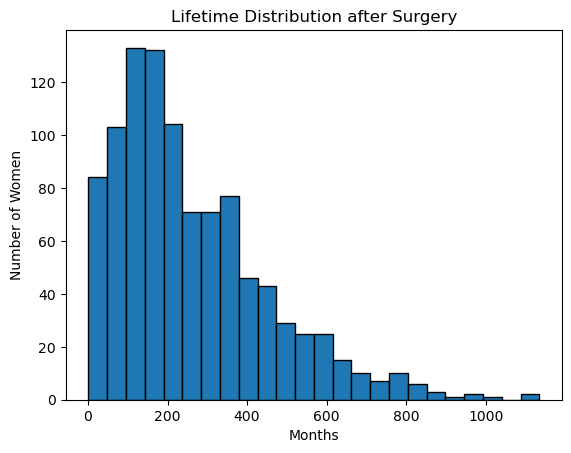

Proportion of women where the cancer reappeared distantly after 30.5 months: 0.6320

The mean of the lifetime distribution is:261.1646
The confidence interval of the mean is:[251.193, 271.1362]

The standard deviation is: 191.4333
The confidence interval is of the standard deviation is:[183.3955, 200.2135]


In [53]:
# Define the probability matrix P
Q = np.array([[-0.0085, 0.005, 0.0025, 0, 0.001],
              [0, -0.014, 0.005, 0.004, 0.005],
              [0, 0, -0.008, 0.003, 0.005],
              [0, 0, 0, -0.009, 0.009],
              [0, 0, 0, 0, 0]])

R=np.zeros((5,5))

for i in range(0,Q.shape[0]-1):
    for j in range(0,Q.shape[1]-1):
        R[i,i]=0
        R[i,j+1]=-Q[i,j+1]/Q[i,i]

# Define the initial distribution p0 with all women starting in state 1
p0 = np.array([1, 0, 0, 0, 0])

# Simulate the lifetime distribution for 1000 women
num_women = 1000
lifetime_continuous = []
local_recurrence_count = 0

for _ in range(num_women):
    state = 0  # Start in state 1 (post-surgery)
    sojourn_time = 0
    new_woman = True

    while state != 4:  # Continue simulation until death (state 5) is reached
        sojourn_time += random.expovariate(-Q[state,state])
        state = np.argmax(np.random.multinomial(1 , R[state,:], size=1))

        if (state == 2 or state == 3) and new_woman == True and sojourn_time >= 30.5:
            local_recurrence_count += 1
            new_woman = False
    lifetime_continuous.append(sojourn_time)

# Calculate the proportion of women where the cancer reappeared locally (state 2)
reappeared_locally = local_recurrence_count/num_women

# Plot the lifetime distribution as a histogram
plt.hist(lifetime_continuous, bins="auto", edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Number of Women')
plt.title('Lifetime Distribution after Surgery')
plt.show()

print("Proportion of women where the cancer reappeared distantly after 30.5 months: {:.4f}".format(reappeared_locally))

print("\nThe mean of the lifetime distribution is:{:.4f}".format(np.mean(lifetime_continuous)))
t = stats.t.ppf(0.95, num_women)
l_ci = st.mean(lifetime_continuous) - t * (st.stdev(lifetime_continuous)/sqrt(num_women))
u_ci = st.mean(lifetime_continuous) + t * (st.stdev(lifetime_continuous)/sqrt(num_women))
print("The confidence interval of the mean is:" + "["+str(np.round(l_ci,4))+", "+str(np.round(u_ci,4))+"]")

s = np.std(lifetime_continuous)
confidence_level = 0.95
# Calculate the critical values
alpha = 1 - confidence_level
df = num_women - 1
chi2_dist = stats.chi2(df)
chi2_lower = chi2_dist.ppf(alpha/2)
chi2_upper = chi2_dist.ppf(1 - alpha/2)
# Calculate the confidence interval
lower_bound = s * np.sqrt(df / chi2_upper)
upper_bound = s * np.sqrt(df / chi2_lower)
print("\nThe standard deviation is:" ,np.round(s,4))
print("The confidence interval is of the standard deviation is:" + "["+str(np.round(lower_bound,4))+", " + str(np.round(upper_bound,4))+"]")

### Task 8

We will now study the empirical lifetime distribution using the previous simulation and compare it to the theoretical prediction. To do so, we begin by decomposing the matrix Q into two subgroups: a 4x4 matrix Qs that pertains to the alive states 1 through 4, and the state 4 where the patient dies.

Next, we take the initial 4D distribution p0 and evolve it over time using the operator exp(Qs*t). The resulting probability distribution is not normalized since it includes the leakage to the excluded state 4. To obtain the probabilities that the patients remain alive, we take the dot product of this distribution with a 4D vector of ones. By essentially summing the entries, we calculate the probabilities of patient survival.

In the code, we define a function F(t) that represents one minus this dot product. This function describes the theoretical supplementary lifetime distribution, capturing the probabilities of patients surviving up to any given time t.

Lastly we perform a χ^2 comparison test of the empirical versus the theoretical method.

Chi-square statistic: 3.83
P-value: 1.0000


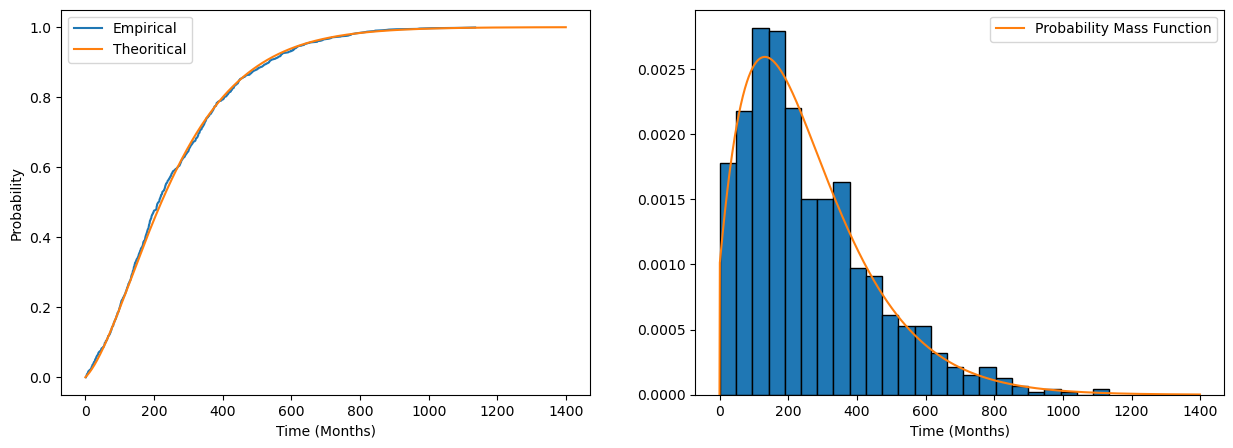

In [54]:
# Define the initial distribution pi with all women starting in state 1
p0 = np.array([1, 0, 0, 0])

# Calculate the sub-matrix Qs
Qs = Q[:4, :4]
ones = np.array([1,1,1,1])

# Calculate the distribution over lifetimes based on the theoretical formula
def cdf(t,M):
    return 1 - p0.dot((expm(M*t).dot(ones)))

# Calculate the observed frequencies in the empirical lifetime distribution
observed_frequencies, bins = np.histogram(lifetime_continuous, density=True, bins=range(1, 122))

# Calculate the expected frequencies based on the theoretical distribution
expected_frequencies = np.array([cdf(t,Qs) for t in range(1, 121)])

# Normalize the expected frequencies to match the sum of observed frequencies
expected_frequencies *= np.sum(observed_frequencies) / np.sum(expected_frequencies)

# Perform the chi-square test to compare the empirical and theoretical distributions
chi2, p_value = stats.chisquare(observed_frequencies, f_exp=expected_frequencies)

# Print the chi-square test results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")

cdf_values = np.array([cdf(t,Qs) for t in range(1400)])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(np.sort(lifetime_continuous), np.array([i/num_women for i in range(num_women)]), label='Empirical')
axs[0].plot(cdf_values, label='Theoritical')
axs[0].set_xlabel('Time (Months)')
axs[0].set_ylabel('Probability')
axs[0].legend()
axs[1].hist(lifetime_continuous, density=True, bins="auto", edgecolor='black')
cdf_values[1:] -= cdf_values[:-1].copy()
axs[1].plot(cdf_values, label='Probability Mass Function')
axs[1].set_xlabel('Time (Months)')
axs[1].legend()
plt.show()

### Task 9

We are now considering a preventative treatment that alters the matrices we have used previously. Following the same procedure as before with a sample of 1000 women starting in state 1 at time 0, we store the times of death for both scenarios and plot the empirical sample mortality.

In this case, we compare our empirical results to the theoretical ones using the survival function instead of the non-survival function F we used before. The survival function is simply defined as 1 minus the non-survival function F, representing the probabilities of patients surviving beyond a given time.

By analyzing the empirical sample mortality and comparing it to the theoretical predictions using the survival function, we can assess the impact of the preventative treatment on the overall survival rates.

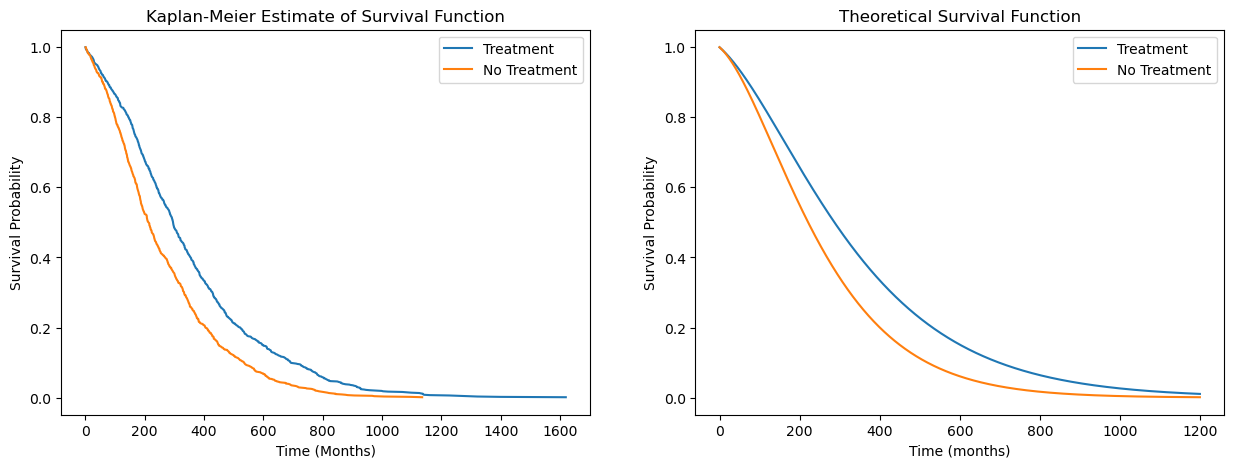

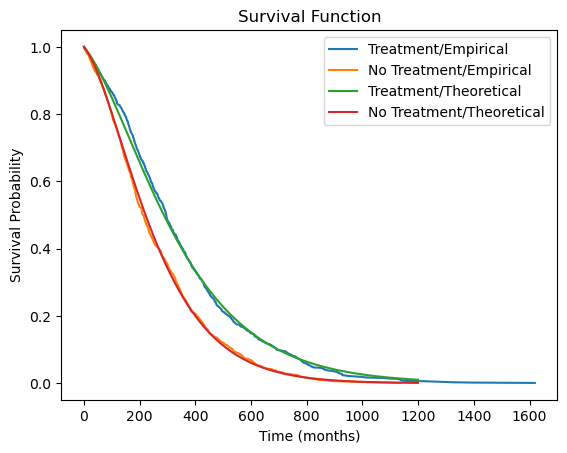

In [55]:
# Define the probability matrix P
Q_treat = np.array([[-0.00475, 0.0025, 0.00125, 0, 0.001],     
                  [0, -0.007, 0, 0.002, 0.005],      
                  [0, 0, -0.008, 0.003, 0.005],        
                  [0, 0, 0, -0.009, 0.009],  
                  [0, 0, 0, 0, 0]])

R_treat=np.zeros((5,5))

for i in range(0,Q_treat.shape[0]-1):
    for j in range(0,Q_treat.shape[1]-1):
        R_treat[i,i]=0
        R_treat[i,j+1]=-Q_treat[i,j+1]/Q_treat[i,i]

# Simulate the lifetime distribution after treatment for 1000 women
num_women = 1000
lifetime_treated = []

for _ in range(num_women):
    state = 0  # Start in state 1 (post-surgery)
    sojourn_treat = 0

    while state != 4:  # Continue simulation until death (state 5) is reached
        sojourn_treat += random.expovariate(-Q_treat[state,state])
        state = np.argmax(np.random.multinomial(1 , R_treat[state,:], size=1))

    lifetime_treated.append(sojourn_treat)

# Calculate the Kaplan-Meier estimate of the survival function for the treated group
times_treatment = np.sort(lifetime_treated)
survival_prob_treatment = [(num_women - i) / num_women for i in range(num_women)]

# Calculate the Kaplan-Meier estimate of the survival function for the non-treated group
times_no_treatment = np.sort(lifetime_continuous)
survival_prob_no_treatment = [(num_women - i) / num_women for i in range(num_women)]

# Theoretical/Analytical Survival Probability of the treated group
Qs_treat = Q_treat[:4, :4]
survival_prob_treatment_theoretical = np.array([1-cdf(t,Qs_treat) for t in range(1200)])

# Theoretical/Analytical Survival Probability of the non-treated group
survival_prob_no_treatment_theoretical = np.array([1-cdf(t,Qs) for t in range(1200)])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plot the Kaplan-Meier estimates of the survival functions
axs[0].plot(times_treatment, survival_prob_treatment, label='Treatment')
axs[0].plot(times_no_treatment, survival_prob_no_treatment, label='No Treatment')
axs[0].set_xlabel('Time (Months)')
axs[0].set_ylabel('Survival Probability')
axs[0].set_title('Kaplan-Meier Estimate of Survival Function')
axs[0].legend()

# Plot the theoretical survival functions
axs[1].plot(survival_prob_treatment_theoretical, label='Treatment')
axs[1].plot(survival_prob_no_treatment_theoretical, label='No Treatment')
axs[1].set_xlabel('Time (months)')
axs[1].set_ylabel('Survival Probability')
axs[1].set_title('Theoretical Survival Function')
axs[1].legend()
plt.show()

# What do you want to plot? Yes
plt.plot(times_treatment, survival_prob_treatment, label="Treatment/Empirical")
plt.plot(times_no_treatment, survival_prob_no_treatment, label='No Treatment/Empirical')
plt.plot(survival_prob_treatment_theoretical, label='Treatment/Theoretical')
plt.plot(survival_prob_no_treatment_theoretical, label='No Treatment/Theoretical')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title("Survival Function")
plt.legend()
plt.show()

### Task 10

Task 10 is optional and we chose to opt out.

### Task 11

Since we have considered a continuous model, the transitions from one state to a worse state can now occur at any time. We are no longer restricted to specific transition times, making rates a more appropriate description of the model. The continuous model is more general and encompasses the discrete model as a special case.

To transition from an exponential distribution to an Erlang distribution with a shape parameter k, we would need to expand the number of states to 5 + (k-1) * 5. In other words, we introduce k states between each pair of original states. The sojourn time for the patient's transition from one state to another can now follow an Erlang distribution. These intermediate states will have matrix entries only for transitions from the current state to the next state. This introduced delay in the transition process is what produces the desired distribution for the sojourn times. In principal introducing a continuum of intermediate states, it becomes possible to generate any desired distribution with set sojourn times.

In summary, by incorporating a greater number of intermediate states we can have an Erlang distribution instead of an exponential for the sojourn times. Also a continuous model in the number of states enables the modeling of a wide range of desired distributions.

## Part 3 - Estimation

### Task 12

In [56]:
# Simulate the lifetime distribution for 1000 women
num_women = 1000
span = 26
stored_time = []
stored_state = []
Y_time = [i*48  for i in range(span)]
Y_state = []
for _ in range(num_women):
    state = 0  # Start in state 1 (post-surgery)
    time = 0
    sub_stored_time = []
    sub_stored_state = []

    while state != 4:
        time += random.expovariate(-Q[state,state])
        state = np.argmax(np.random.multinomial(1 , R[state,:], size=1))

        sub_stored_time.append(time)
        sub_stored_state.append(state)


    stored_time.append(sub_stored_time)
    stored_state.append(sub_stored_state)
    Y_sub = np.zeros(span)

    for n in range(len(sub_stored_time)):
        m = math.floor(sub_stored_time[n]/48)
        Y_sub[m:] = sub_stored_state[n]

    Y_state.append(Y_sub)

for i in range(num_women):
    Y_state[i]  = [x for x in Y_state[i] if x != 4]
    Y_state[i] = Y_state[i] + [4]
    #print(Y_state[i])
    

### Task 13

In [57]:
# Function that calculates the infinity norm of a matrix

def infinity_norm(matrix):
    # Calculate the absolute sum of each row
    row_sums = np.sum(np.abs(matrix), axis=1)
    # Find the maximum absolute sum
    max_sum = np.max(row_sums)
    return max_sum

# Function that calculates the infinity norm of the element wise difference of two matrices

def matrix_subtraction_norm(matrix1, matrix2):
    # Subtract the matrices
    result_matrix = matrix1 - matrix2
    # Calculate the infinity norm of the result matrix
    norm = infinity_norm(result_matrix)
    return norm

# Function that generates the list Y of time series Yi of all women

def generate_Y_state(Q,R):
    # Simulate the lifetime distribution for 1000 women
    num_women = 1000
    span = 26
    stored_time = []
    stored_state = []
    Y_time = [i*48  for i in range(span)]
    Y_state = []
    for _ in range(num_women):
        state = 0  # Start in state 1 (post-surgery)
        time = 0
        sub_stored_time = []
        sub_stored_state = []

        while state != 4:
            time += random.expovariate(-Q[state,state])
            state = np.argmax(np.random.multinomial(1 , R[state,:], size=1))
            
            sub_stored_time.append(time)
            sub_stored_state.append(state)

        stored_time.append(sub_stored_time)
        stored_state.append(sub_stored_state)
        Y_sub = np.zeros(span)

        for n in range(len(sub_stored_time)):
            m = math.floor(sub_stored_time[n]/48)
            Y_sub[m:] = sub_stored_state[n]

        Y_state.append(Y_sub)

    for i in range(num_women):
        Y_state[i]  = [x for x in Y_state[i] if x != 4]
        Y_state[i] = Y_state[i] + [4]

    return Y_state

# Function that creates the Q and R matrices based on Y_states

def create_Qnew_Rnew(Y_state):
    # Create matrix of total number of jumps from state i to state j N_ij and vector of total sojourn times in state i S_i

    N = [[0 for _ in range(5)] for _ in range(5)]
    S = np.zeros(5)

    for i in range(num_women):
        for k in range(len(Y_state[i])-1):
            if  Y_state[i][k+1] - Y_state[i][k] != 0:
                N[int(Y_state[i][k])][int(Y_state[i][k+1])] +=1
        unique_values, count = np.unique(Y_state[i], return_counts=True)
        for j in range(len(count)-1):
            S[int(unique_values[j])] += 48*count[j]

    # Create transition-rate matrix

    Q_new = np.zeros((len(N),len(N)))
    for i in range(len(N)-1):
        Q_new[i] = N[i]/S[i]
        Q_new[i][i] = - sum(Q_new[i])
    #print(Q_new)

    # Create probabilities matrix

    R_new=np.zeros((5,5))
    for i in range(0,Q_new.shape[0]-1):
        for j in range(0,Q_new.shape[1]-1):
            R_new[i,i]=0
            R_new[i,j+1]=-Q_new[i,j+1]/Q_new[i,i]
    #print(r)
    return Q_new, R_new

In [58]:
tol = 1e-3
iter = 0
num_women = 1000
span = 26

Q = np.array([[-0.0085, 0.005, 0.0025, 0, 0.001],
              [0, -0.014, 0.005, 0.004, 0.005],
              [0, 0, -0.008, 0.003, 0.005],
              [0, 0, 0, -0.009, 0.009],
              [0, 0, 0, 0, 0]])

R = np.zeros((5,5))

for i in range(0,Q.shape[0]-1):
    for j in range(0,Q.shape[1]-1):
        R[i,i]=0
        R[i,j+1]=-Q[i,j+1]/Q[i,i]

Q_old = Q
R_old = R

convergence = False

while convergence == False:
    iter += 1
    # print(iter)
    
    # Generate Y_state
    Y_i = generate_Y_state(Q_old,R_old)
    # print(Y_i)
    # print()

    # Create new Q and R matrices
    Q_new ,R_new =create_Qnew_Rnew(Y_i)
    # print(Q_new)
    # print()
    # print(R_new)
    # print()
    
    # Check convergence criterion
    norm = matrix_subtraction_norm(Q_old, Q_new)
    # print(norm)
    # print()
    if norm < tol:
        print("Convergence criterion is reached after",iter,"iterations and the matrix norm is equal to :{:.6f}".format(norm))
        convergence = True
    Q_old = Q_new
    R_old = R_new

Convergence criterion is reached after 7 iterations and the matrix norm is equal to :0.000691


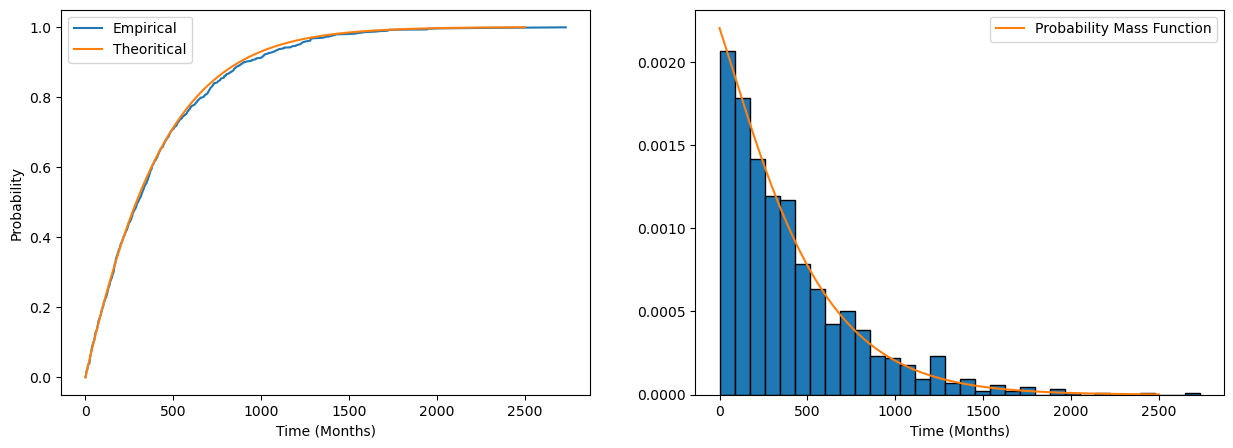

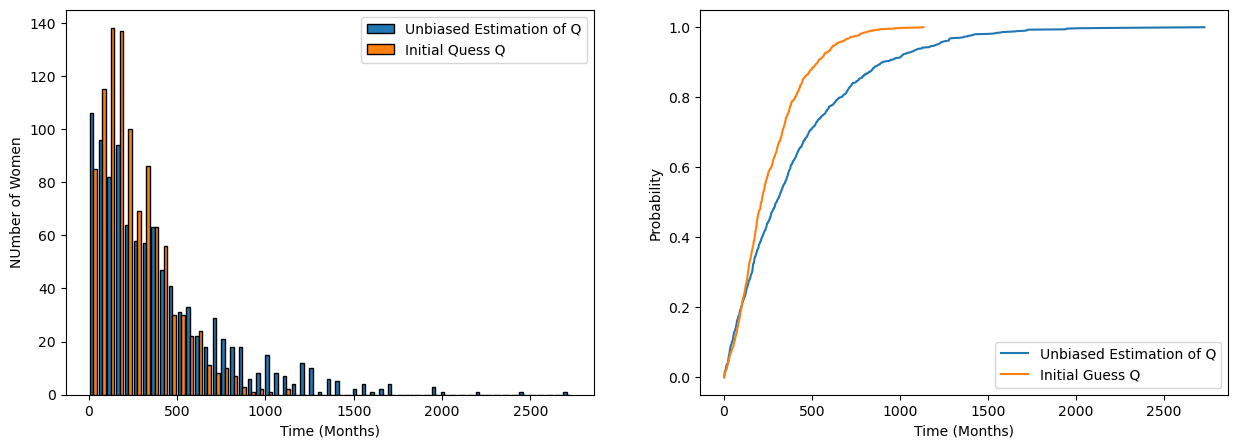

[[-0.00350336  0.00050109  0.00045013  0.00034821  0.00220393]
 [ 0.         -0.00368118  0.00056018  0.00040013  0.00272087]
 [ 0.          0.         -0.00370098  0.00036765  0.00333333]
 [ 0.          0.          0.         -0.00477127  0.00477127]
 [ 0.          0.          0.          0.          0.        ]]


In [59]:
# Simulate the lifetime distribution for 1000 women
num_women = 1000
lifetime = []

for _ in range(num_women):
    state = 0  # Start in state 1 (post-surgery)
    sojourn_time = 0

    while state != 4:  # Continue simulation until death (state 5) is reached
        sojourn_time += random.expovariate(-Q_old[state,state])
        state = np.argmax(np.random.multinomial(1 , R_old[state,:], size=1))

    lifetime.append(sojourn_time)

Qs_old = Q_old[:4, :4]
cdf_values_opt = np.array([cdf(t,Qs_old) for t in range(2500)])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(np.sort(lifetime), np.array([i/num_women for i in range(num_women)]), label='Empirical')
axs[0].plot(cdf_values_opt, label='Theoritical')
axs[0].set_xlabel('Time (Months)')
axs[0].set_ylabel('Probability')
axs[0].legend()
axs[1].hist(lifetime, density=True, bins="auto", edgecolor='black')
cdf_values_opt[1:] -= cdf_values_opt[:-1].copy()
axs[1].plot(cdf_values_opt[1:], label='Probability Mass Function')
axs[1].set_xlabel('Time (Months)')
axs[1].legend()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist([lifetime,lifetime_continuous], bins = "auto", edgecolor="black", label=["Unbiased Estimation of Q","Initial Quess Q"])
axs[0].set_xlabel('Time (Months)')
axs[0].set_ylabel('NUmber of Women')
axs[0].legend()
sorted_lifetime = np.sort(lifetime)
axs[1].plot(sorted_lifetime, np.arange(num_women)/num_women, label="Unbiased Estimation of Q")
axs[1].plot(np.sort(lifetime_continuous), np.arange(num_women)/num_women, label="Initial Guess Q")
axs[1].set_xlabel('Time (Months)')
axs[1].set_ylabel('Probability')
axs[1].legend()
plt.show()

print(Q_old)